In [1]:
import argparse
import open_clip
from testing.data import get_dataset_fn
import pandas as pd
import numpy as np
import json
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision.datasets import VisionDataset
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import transforms
import unicodedata
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import datasets
from dosnes import dosnes
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def encode_labels(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels_encoded = le.transform(labels)
    return labels_encoded

def plot_dosnes(dosnes_model, features, labels, title):
    X_embedded = model.fit_transform(features)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=labels, cmap=plt.cm.Set1)
    plt.title(title)
    plt.show()
    
def fit_PCA(features, labels):
    df = pd.DataFrame({'feature': features, 'label': labels})
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(features)

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    return df

def plot_pca(df, label, title, c_palette=sns.color_palette('bright')):
    plt.figure(figsize=(16,10))
    fig = plt.figure()
    sns.set(style = "darkgrid")
    ax = fig.add_subplot(111, projection = '3d')
    x = df["pca-one"]
    y = df["pca-two"]
    z = df['pca-three']
    ax.scatter(x, y, z, label=label)
    plt.title(title)
    plt.show

In [4]:
#model_name = 'ViT-B-32'
#model_name = 'ViT-M-32'
model_name = 'ViT-L-16'
tokenizer = open_clip.get_tokenizer(model_name)
model, _, preprocess = open_clip.create_model_and_transforms(model_name, device='cuda')
#model, _, preprocess = open_clip.create_model_and_transforms(model_name, device='cuda', align=True)

In [5]:
#alignCLIP_path = '/scratch4/seslami/alignCLIP_openCLIP/alignCLIP/logs/2023_08_16-09_51_36-model_ViT-B-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_30.pt'  ## 512 -> 412
#alignCLIP_path = '/scratch4/seslami/alignCLIP_openCLIP/alignCLIP/logs/2023_08_22-16_09_33-model_ViT-B-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_30.pt'  ## 512 -> 1024
#alignCLIP_path = '/scratch/seslami/alignCLIP_openCLIP/alignCLIP/logs/2023_09_04-14_15_48-model_ViT-B-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_30.pt'  ## 512 -> 256
#checkpoint = torch.load(alignCLIP_path)
#************************************************
#orgCLIP_path = '/scratch4/seslami/alignCLIP_openCLIP/logs/2023_08_15-16_04_16-model_ViT-B-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_30.pt'
#orgCLIP_path = '/scratch/seslami/alignCLIP_openCLIP/logs/2023_09_12-10_35_38-model_ViT-M-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_30.pt'  # ViT-M
#checkpoint = torch.load(orgCLIP_path)
#************************************************
#inModalityCLIP_path = '/scratch/seslami/alignCLIP_openCLIP/alignCLIP/inModality/logs/2023_09_13-15_47_50-model_ViT-M-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_30.pt'  # InModality Contrastive loss
#checkpoint = torch.load(inModalityCLIP_path)
#************************************************
#sharedTransformerCLIP_path = '/scratch/seslami/alignCLIP_openCLIP/shared_transformer_projector/logs/2023_09_27-16_44_09-model_ViT-M-32-lr_0.001-b_520-j_2-p_amp/checkpoints/epoch_20.pt'  # CLIP with shared transformer and projector
sharedTransformerCLIP_path = '/scratch/seslami/alignCLIP_openCLIP/shared_transformer_projector/logs/2023_10_03-13_00_36-model_ViT-L-16-lr_0.001-b_256-j_2-p_amp/checkpoints/epoch_30.pt'  # CLIP modified ViT-L with shared transformer and projector
checkpoint = torch.load(sharedTransformerCLIP_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [9]:
def clip_I_T_embeddings(dataloader, model, device='cuda', align=False):
    features_I = []
    features_T = []
    with torch.no_grad():
        for i, (images, captions) in enumerate(dataloader):
            images = torch.stack([img for img in images], dim=0).to(device)

            image_features = model.encode_image(images).to(torch.float32)
            image_featues = image_features / image_features.norm(dim=-1, keepdim=True)
            if align:
                image_features = model.adapter(image_features)
            features_I += image_features

            captions = captions.to(device)
            text_features = model.encode_text(captions).to(torch.float32)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            if align:
                text_features = model.adapter(text_features)
            features_T += text_features
            
    return features_I, features_T



def align_separation_scores(x, y, is_normalized=False):
    #return cos(x, y).mean()
    if not is_normalized:
        x = x / x.norm(dim=-1, keepdim=True)
        y = y / y.norm(dim=-1, keepdim=True)
        
    inner_p = x @ y.T
    diagon = inner_p.diagonal()
    align_score = diagon.mean()

    inner_p.diagonal(dim1=-1, dim2=-2).zero_()
    separation_score = 1 - inner_p.mean()
    
    return align_score, separation_score

## CC3M Validation

In [6]:
data_path = '/scratch/datasets/vision_language/conceptual_captions/Validation_GCC-1.1.0-Validation_output.tsv'
data = get_dataset_fn(data_path=data_path, dataset_type='auto')(data_path, preprocess, is_train=False, tokenizer=tokenizer)

In [10]:
features_I, features_T = clip_I_T_embeddings(data.dataloader, model)
#features_I, features_T = clip_I_T_embeddings(data.dataloader, model, align=True)
features_I = torch.stack(features_I, dim=0)
features_T = torch.stack(features_T, dim=0)
    
align_score, separation_score = align_separation_scores(features_I, features_T)


In [11]:
print(align_score)
print(separation_score)

tensor(0.6271, device='cuda:0')
tensor(0.7456, device='cuda:0')


In [9]:
np.random.seed(42)
vis_size = 2500
msk = np.random.rand(vis_size)

In [10]:
features = torch.concat((features_I[msk], features_T[msk]), dim=0)
features.shape

torch.Size([5000, 512])

In [11]:
features = features.cpu().detach().numpy()
features.shape

(5000, 512)

In [12]:
#labels = [0 for i in range(features_I.shape[0])] + [1 for i in range(features_T.shape[0])]
labels = [0 for i in range(vis_size)] + [1 for i in range(vis_size)]
#labels = [0 for i in range(1000)] + [1 for i in range(1000)]
labels = np.array(labels)
assert labels.shape[0] == features.shape[0]

### DOSNES

In [15]:
metric = "cosine"
model = dosnes.DOSNES(metric = metric, verbose = 1, random_state=42, max_iter=1000, max_iter_skp=200)
X_embedded = model.fit_transform(features)

Computing distances
Set doubly Stochastic
Start Embedding
Iteration 0 : error is 0.00011192846421081981
Iteration 10 : error is 0.00011192846422858338
Iteration 20 : error is 0.00011192846421081981
Iteration 30 : error is 0.00011192846416108182
Iteration 40 : error is 0.00011192846402963141
Iteration 50 : error is 0.00011192846321605998
Iteration 60 : error is 0.00011192845865792833
Iteration 70 : error is 0.00011192841809659626
Iteration 80 : error is 0.00011192770600843005
Iteration 90 : error is 0.00011190616920586649
Iteration 100 : error is 0.00011101239945787711
Iteration 110 : error is 7.137425325964841e-05
Iteration 120 : error is 3.718067560498639e-07
Iteration 130 : error is 4.893401239769446e-10
Iteration 140 : error is 5.016431714466307e-12
Iteration 150 : error is 8.668621376273222e-13
Iteration 160 : error is 8.242295734817162e-13
Iteration 170 : error is 7.709388682997087e-13
Iteration 180 : error is 8.029132914089132e-13
Iteration 190 : error is 7.815970093361102e-13
It

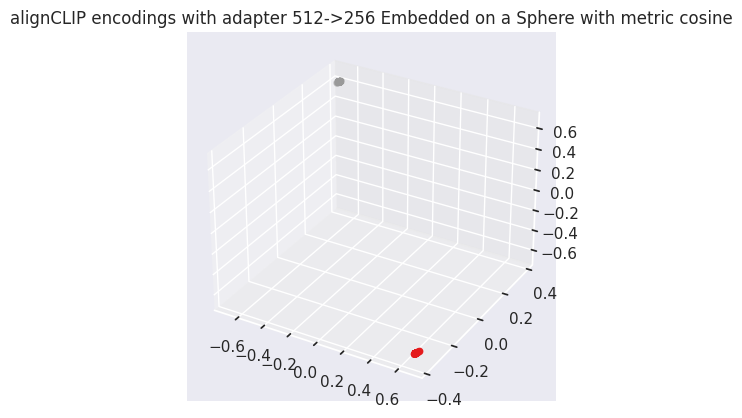

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=labels, cmap=plt.cm.Set1)
plt.title("alignCLIP encodings with adapter 512->256 Embedded on a Sphere with metric {}".format(metric))
#plt.title("orgCLIP encodings Embedded on a Sphere with metric {}".format(metric))
plt.show()

### PCA 3D

In [13]:
df = fit_PCA(features.tolist(), labels)

<Figure size 1600x1000 with 0 Axes>

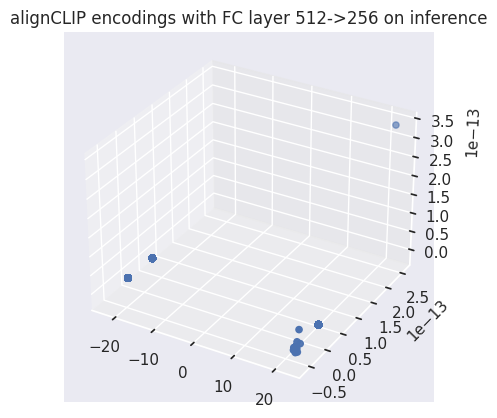

In [14]:
plot_pca(df, labels, title='alignCLIP encodings with FC layer 512->256 on inference')